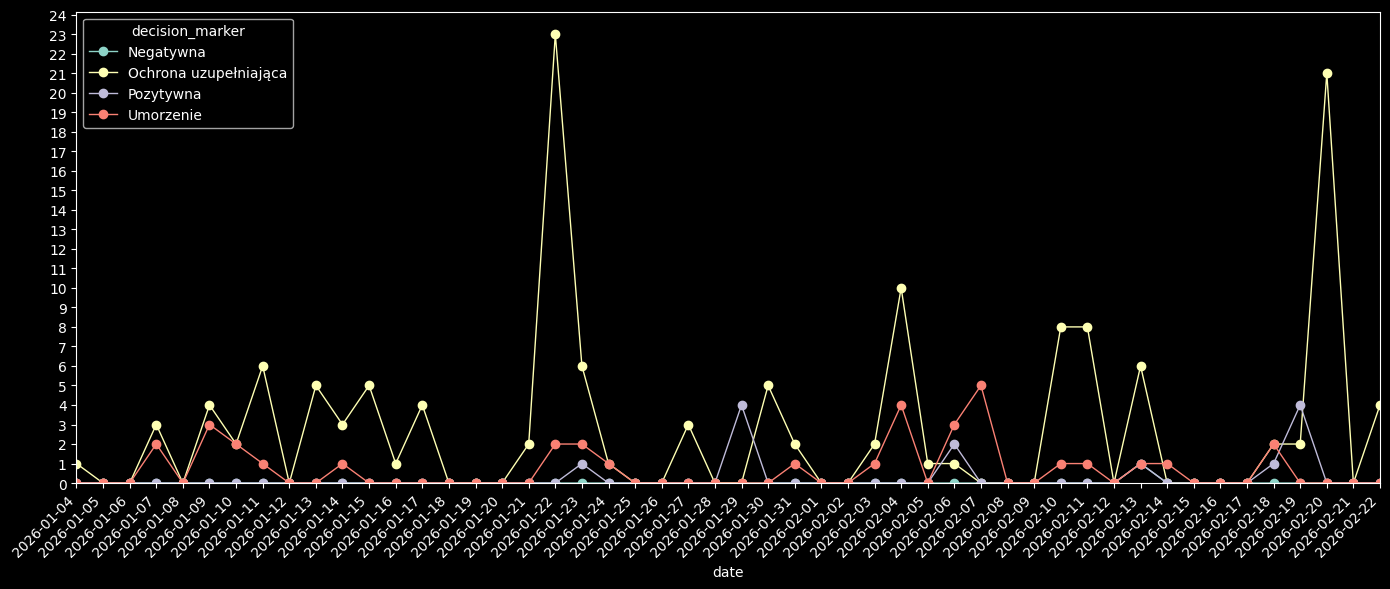

In [2]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

db_path = (Path("tracker.db")).resolve()


YEAR = 2026

conn = sqlite3.connect(db_path)

def daily_from_cumulative(df: pd.DataFrame,
                          group_col: str,
                          ts_col: str = "ts",
                          count_col: str = "count") -> pd.DataFrame:

    work = df[[ts_col, count_col, group_col]].copy()
    work[ts_col] = pd.to_datetime(work[ts_col], utc=True)
    work["date"] = work[ts_col].dt.floor("D")
    daily_snap = (work
                  .groupby(["date", group_col], as_index=False)[count_col]
                  .max()
                  .sort_values([group_col, "date"])
                  )

    frames = []
    for g, gdf in daily_snap.groupby(group_col, sort=False):
        idx = pd.date_range(gdf["date"].min(), gdf["date"].max(), freq="D", tz="UTC")
        s = gdf.set_index("date")[count_col].reindex(idx).ffill()
        d = s.diff().fillna(s).clip(lower=0)
        frames.append(d.rename(g))
    delta = pd.concat(frames, axis=1).fillna(0)
    delta.index.name = "date"
    delta.index = delta.index.tz_convert(None)
    return delta

with conn:
    start_ms = int(pd.Timestamp(f"{YEAR}-01-01 00:00:00", tz="UTC").timestamp() * 1000)
    end_ms   = int(pd.Timestamp(f"{YEAR+1}-01-01 00:00:00", tz="UTC").timestamp() * 1000)

    sql = f"""
    SELECT
      d.id               AS decision_id,
      d.count            AS count,
      d.country          AS country,
      u.timestamp        AS ts,
      u.dataUpdated      AS dataUpdated,
      it.name            AS institution,
      ct.type            AS case_type,
      dm.description     AS decision_marker
    FROM decisions d
    JOIN updates u           ON u.dateId  = d.dateId
    JOIN institution it     ON it.id = d.institution
    JOIN caseType ct       ON ct.id = d.caseType
    JOIN decisionMarker dm ON dm.id = d.decisionMarker
    WHERE
      u.timestamp >= :start_ms
      AND u.timestamp <  :end_ms
--       AND u.dataUpdated > 0
      AND
      d.country=241 AND case_type='Ochrona międzynarodowa' AND (it.id=1516 OR it.id=810)
    ORDER BY
      u.timestamp ASC,
      ct.type ASC,
      dm.description ASC
    """
    params = {"start_ms": start_ms, "end_ms": end_ms}

    df = pd.read_sql_query(sql, conn, params=params)
    df["ts"] = pd.to_datetime(df["ts"], unit="ms", utc=True)
    df["date"] = df["ts"].dt.floor("D")
    daily = (
        df.groupby(["date", "decision_marker"])["count"]
        .sum()
        .reset_index()
        .sort_values(["decision_marker", "date"])
    )
    daily["cumulative"] = (
        daily.groupby("decision_marker")["count"]
        .cumsum()
    )
    daily["delta"] = daily.groupby("decision_marker")["cumulative"].diff().fillna(daily["cumulative"])
    pivot = daily.pivot(index="date", columns="decision_marker", values="delta").fillna(0)
    delta = pivot.diff().fillna(pivot)
    delta.index = pd.to_datetime(delta.index)
    if delta.index.tz is not None:
        delta.index = delta.index.tz_convert(None)

    delta = delta.asfreq("D", fill_value=0)

    fig, ax = plt.subplots(figsize=(14, 6))
    delta.plot(ax=ax, marker="o", linewidth=1)

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(bottom=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # for i, label in enumerate(ax.get_xticklabels()):
    #     if i % 7 != 0:
    #         label.set_visible(False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
